<a href="https://colab.research.google.com/github/junhyeok8696/NLP/blob/main/035_naver_movie_reivew_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화평 감성 분류

- 한글 형태소 분석기 Okt 사용 전처리  

- Keras Tokenizer, pad_sequences 함수 사용

In [55]:
!pip install -q KoNLPy

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM

In [57]:
DATA_TRAIN_PATH = tf.keras.utils.get_file("ratings_train.txt",
                        "https://raw.githubusercontent.com/junhyeok8696/NLP/main/naver_movie/ratings_train.txt")
DATA_TEST_PATH = tf.keras.utils.get_file("ratings_test.txt",
                        "https://raw.githubusercontent.com/junhyeok8696/NLP/main/naver_movie/ratings_test.txt")

In [58]:
train_data = pd.read_csv(DATA_TRAIN_PATH, delimiter = '\t')
print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [59]:
test_data = pd.read_csv(DATA_TEST_PATH, delimiter = '\t')
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 훈련 시간을 감안하여 data size 축소
- sample() = data를 random하게 샘플링
- train : 150000 -> 50000 개로 축소
- test  : 50000 -> 5000 개로 축소

In [60]:
train_data = train_data.sample(n = 50000, random_state = 1)
test_data = test_data.sample(n = 5000, random_state = 1)

print(train_data.shape)
print(test_data.shape)

(50000, 3)
(5000, 3)


**null 값 확인 후 제거**

In [61]:
train_data.isnull().sum(), test_data.isnull().sum()

(id          0
 document    3
 label       0
 dtype: int64,
 id          0
 document    0
 label       0
 dtype: int64)

In [62]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [63]:
train_data.isnull().sum(), test_data.isnull().sum()

(id          0
 document    0
 label       0
 dtype: int64,
 id          0
 document    0
 label       0
 dtype: int64)

### okt.morphs()

- 텍스트를 형태소 단위로 나눈다. 옵션으로는 norm과 stem이 있다
- stem은 각 단어에서 어간을 추출하는 기능

In [64]:
okt = Okt()
test = "아버지가방에들어가신다"
okt.morphs(test, stem=True)

['아버지', '가방', '에', '들어가다']

## Text Data 전처리

**한글 문자가 아닌 것 모두 제거**

In [65]:
# 영어 -> '[a-zA-Z]'
# 한글 -> '[^가-힣ㄱ-ㅎㅏ-ㅣ ]'

In [66]:
def preprocessing(sentence, remove_stopwords=True):
    # 불용어 제거
    # stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    stop_words = []

    sentence = re.sub('\\\\n', ' ', sentence)              # 개행문자 제거
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '', sentence)  # 한글외에 모두 제거
    sentence = okt.morphs(sentence, stem=True)
    if remove_stopwords:
        sentence = [token for token in sentence if not token in stop_words]
    return sentence

In [67]:
%%time
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

start = time.time()

for i, (sent, label) in enumerate(zip(train_data['document'], train_data['label'])):
    if i % 10000 == 0:
        print(f"Train processed = {i}")
    sent = preprocessing(sent)
    if len(sent) > 0:
        train_sentences.append(sent)
        train_labels.append(label)

for i, (sent, label) in enumerate(zip(test_data['document'], test_data['label'])):
    if i % 1000 == 0:
        print(f"Test processed = {i}")
    sent = preprocessing(sent)
    if len(sent) > 0:
        test_sentences.append(sent)
        test_labels.append(label)

print(time.time() - start)

Train processed = 0
Train processed = 10000
Train processed = 20000
Train processed = 30000
Train processed = 40000
Test processed = 0
Test processed = 1000
Test processed = 2000
Test processed = 3000
Test processed = 4000
272.66785502433777
CPU times: user 4min 37s, sys: 1.08 s, total: 4min 38s
Wall time: 4min 32s


## train_labels, test_labels  list를 numpy array 로 변환

In [68]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(49571,)
(4951,)


## train_sentences, test_sentences text 를 sequence 로 변환

In [69]:
VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = '<OOV>')
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(train_sequences[0])
print(test_sequences[0])

[90, 1370, 13, 1554, 80, 520, 8870, 14637, 29, 250, 5, 3884, 16, 430, 62, 210, 30, 1612, 14, 744, 22, 229, 6, 1123, 13, 31, 43, 12, 149, 2547, 5, 741, 12, 1554, 14638, 6007, 8871, 8872, 8, 31]
[1683, 7, 460, 1491, 106, 346, 37, 2485, 344, 760, 206, 650, 96, 270]


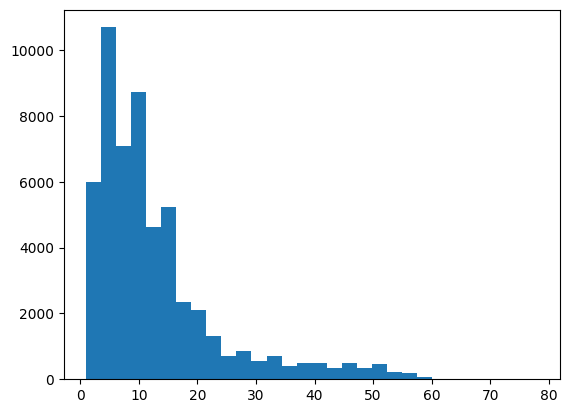

In [70]:
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins = 30);

In [71]:
max_length = 15

train_padded = pad_sequences(train_sequences, maxlen = max_length, padding = 'post', truncating = 'post')
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = 'post', truncating = 'post')

print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])
print(test_padded[0])

(49571, 15)
(4951, 15)
[   90  1370    13  1554    80   520  8870 14637    29   250     5  3884
    16   430    62]
[1683    7  460 1491  106  346   37 2485  344  760  206  650   96  270
    0]


### sequence 를 다시 문장으로 역변환

In [72]:
def decode_sentence(sequence):
    return ' '.join([tokenizer.index_word.get(i, '<pad>') for i in sequence])

print(decode_sentence(train_padded[4]))
print()
print(train_sentences[4])

우리나라 용가리 가 배다 더 자다 만들다 이렇다 류 영화 도 개봉 을 하나 보다

['우리나라', '용가리', '가', '배다', '더', '자다', '만들다', '이렇다', '류', '영화', '도', '개봉', '을', '하나', '보다']


In [73]:
model = Sequential([
    Embedding(VOCAB_SIZE + 1, 64),
    Bidirectional(LSTM(64)),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280064   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1350273 (5.15 MB)
Trainable params: 1350273 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
epochs = 30
history = model.fit(train_padded, train_labels, epochs = epochs,
                    batch_size = 128,
                    validation_data = (test_padded, test_labels),
                    verbose = 1)

Epoch 1/30
388/388 [==============================] - 4s 11ms/step - loss: 0.2170 - accuracy: 0.9109 - val_loss: 0.4861 - val_accuracy: 0.8091
Epoch 2/30
388/388 [==============================] - 6s 14ms/step - loss: 0.1821 - accuracy: 0.9246 - val_loss: 0.5453 - val_accuracy: 0.8073
Epoch 3/30
388/388 [==============================] - 4s 10ms/step - loss: 0.1555 - accuracy: 0.9356 - val_loss: 0.5949 - val_accuracy: 0.8071
Epoch 4/30
388/388 [==============================] - 4s 11ms/step - loss: 0.1338 - accuracy: 0.9463 - val_loss: 0.6866 - val_accuracy: 0.7994
Epoch 5/30
388/388 [==============================] - 4s 11ms/step - loss: 0.1149 - accuracy: 0.9535 - val_loss: 0.7611 - val_accuracy: 0.8025
Epoch 6/30
388/388 [==============================] - 4s 12ms/step - loss: 0.1030 - accuracy: 0.9588 - val_loss: 0.7931 - val_accuracy: 0.8023
Epoch 7/30
388/388 [==============================] - 4s 9ms/step - loss: 0.0901 - accuracy: 0.9641 - val_loss: 0.8474 - val_accuracy: 0.7928


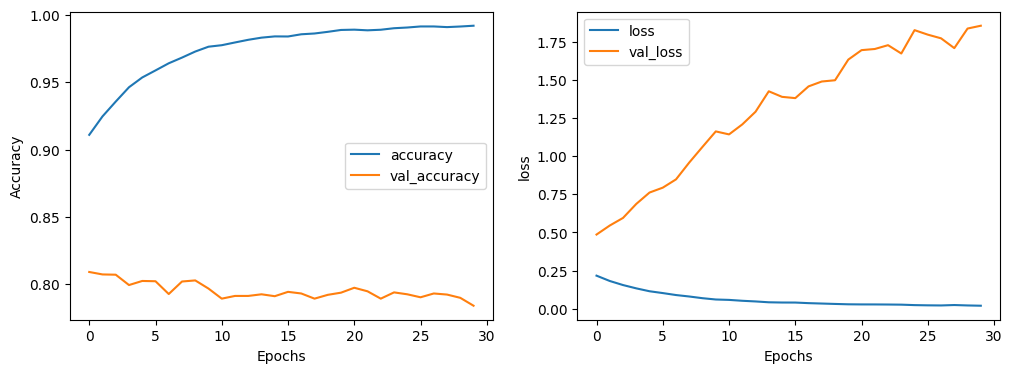

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['accuracy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])

plt.show()

In [77]:
test_data.head()

,id,document,label
26247,5933705,크리스마스에 어울리는 시원한 액션. 긴장감과 박진감 넘치는 전개 엄청난 마지막부분,1
35067,5092284,또 봐도 재밌네요 ㅋ2편은 평점이거지네요;;,1
34590,4501201,완전유치뽕짝저질삼류영화..티비편이 훨씬낫다...,0
16668,8848074,이건 보는 영화가 아니다.,0
12196,178689,오랜만에 접한 수작...30대 중반 이상분들에게 추천!,1


In [78]:
sample_text1 = ['이 영화는 정말 짜증나서 못 보겠다']
sample_text2 = ['오랜만에 정말 재미있는 영화였다']

sample_seq1 = tokenizer.texts_to_sequences(sample_text1)
sample_seq2 = tokenizer.texts_to_sequences(sample_text2)

sample_padded1 = pad_sequences(sample_seq1, maxlen=max_length, padding='post', truncating='post')
sample_padded2 = pad_sequences(sample_seq2, maxlen=max_length, padding='post', truncating='post')

print(sample_padded1)
print(sample_padded2)

[[ 2  1 21  1 49  1  0  0  0  0  0  0  0  0  0]]
[[ 1 21  1  1  0  0  0  0  0  0  0  0  0  0  0]]


In [84]:
print(model.predict(sample_padded1))
print(model.predict(sample_padded2))

1/1 [==============================] - 0s 22ms/step
[[0.01189141]]
1/1 [==============================] - 0s 24ms/step
[[0.89768875]]


In [88]:
print('긍정' if model.predict(sample_padded1) >= 0.5 else '부정')
print('긍정' if model.predict(sample_padded2) >= 0.5 else '부정')

1/1 [==============================] - 0s 24ms/step
부정
1/1 [==============================] - 0s 24ms/step
긍정


In [89]:
model.layers

## Embedding Layer 시각화

- Embedding projector https://projector.tensorflow.org/  를 이용하여 word embedding 시각화

In [90]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20001, 64)


### embedding layer 의 weight 를 disk 에 write. Embedding projector 사용을 위해 embedding vector file 과 단어가 들어 있는 meta data file 로 구분하여 upload.

In [91]:
out_v = open('vects.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')

for i in range(1, 1000):
    word = tokenizer.index_word.get(i, '?')
    embeddings = weights[i]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()

## Embedding 결과 확인

[Embedding Projector](https://projector.tensorflow.org) 에 접속하여 embedding 의 품질 확인

Google Colab 의 경우 local PC 로 download 받아 Embedding Projector 에 upload

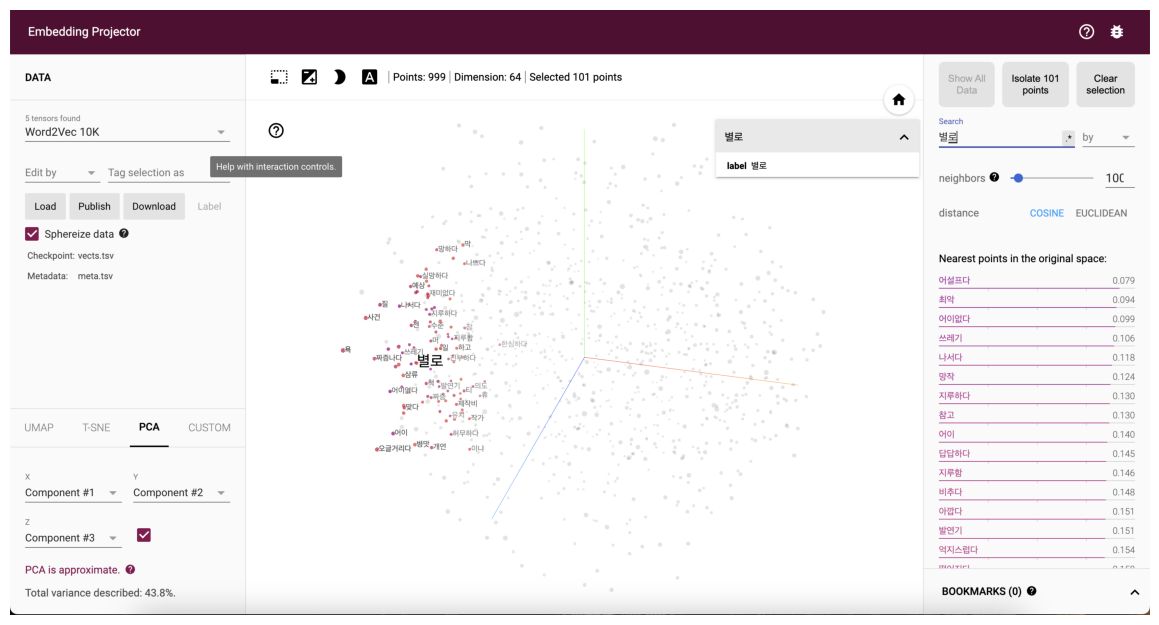

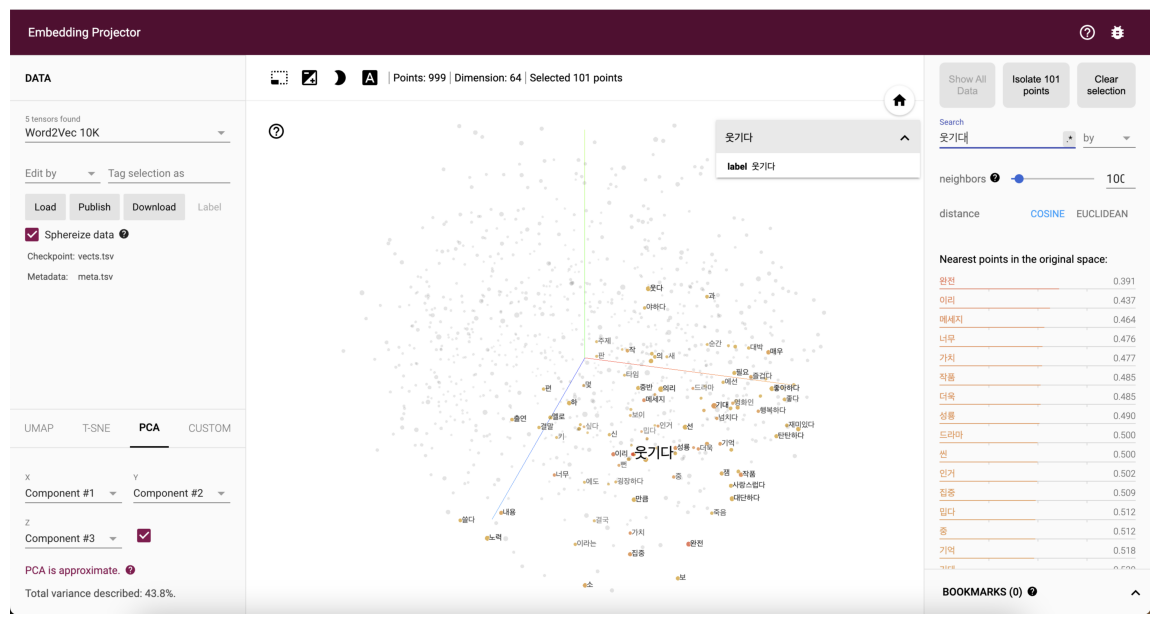

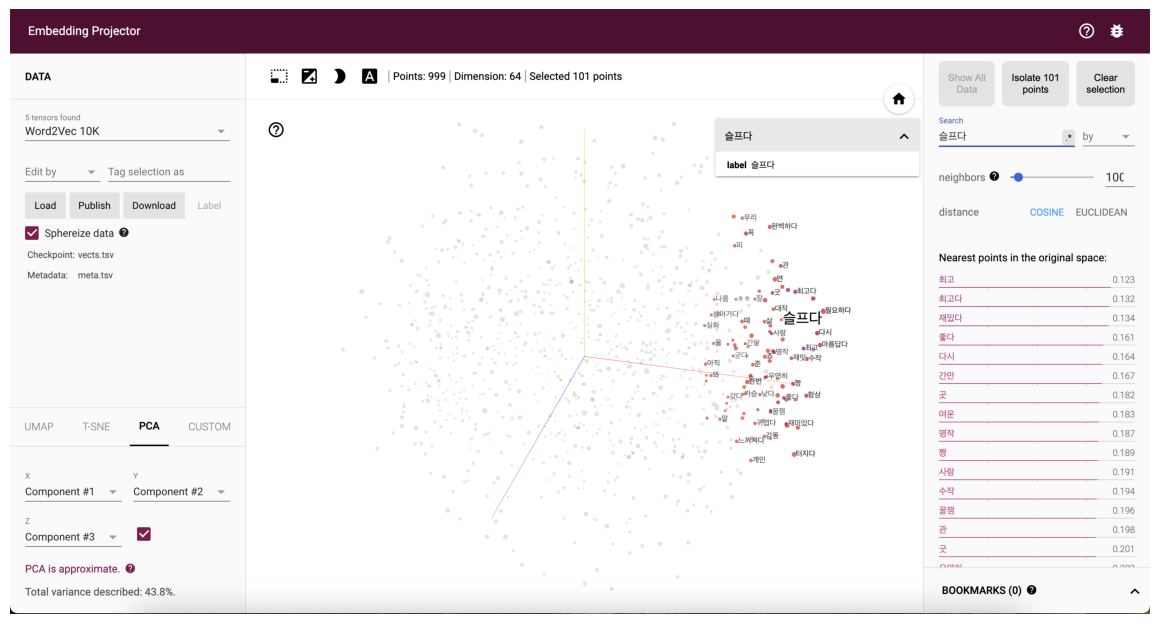

In [101]:
images_paths = [
    '/content/drive/MyDrive/인프런_NLP/1.png',
    '/content/drive/MyDrive/인프런_NLP/2.png',
    '/content/drive/MyDrive/인프런_NLP/3.png'
]

images = [cv2.imread(path) for path in images_paths]

for i, image in enumerate(images):
    plt.figure(figsize=(50,50))
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()